In [28]:
source('utils.r')
source('selinf_functions.r')
source('metrics.r')
source('data_generator.r')
source('cov_matrix.r')

## Selecting optimal lambda
Up to this point we have computed Selective Inference results with a fixed value of lambda, to have faster computation. Here we test a single example with the inclusion of lambda selection, to test the computational time required, and eventual improvements in performance.

In [21]:
set.seed(0)

n_subjects= 25
n_observations = 4
n = n_subjects * n_observations
p = 200
q = 0
SNR = 4
prop_relevant = 0.1

data <- data_generator(n_subjects, n_observations, p, q, SNR, prop_relevant, rho=0.25)
X <- data$X
subjects <- data$subjects
y <- data$y
beta <- data$beta
sd <- data$sd

## Lasso selection

In [22]:
fixed_form = as.formula(
    paste("y ~ 1 +",paste("X", 1:p, sep="", collapse='+'),sep="")
  )

rand_form = list(subjects =~ 1)


selFun <- function(y) selFun_adapting_lambda(X, subjects, y, fixed_form, rand_form)

sel <- selFun(y)
sel_vec <- sel$vec
sel_names <- sel$names
lambda <- sel$lambda
print(metrics(sel_vec,c(TRUE,beta!=0)))

[1] 98.60833
$tpr
[1] 0.2857143

$fdr
[1] 0.5384615



In [23]:
## Adding Selective Inference
# Now we can define the function checking the congruency
# with the original selection
checkFun <- function(yb){

  all(selFun(yb)$vec == sel_vec)

}

sel_form = as.formula(
  paste("y ~ ",paste(sel_names[2:length(sel_names)], collapse='+'), "+ (1|subjects)")
)

final_model = lmer(formula = sel_form, data=data.frame(X, subjects, y))

boundary (singular) fit: see help('isSingular')



In [24]:
final_model

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: sel_form
   Data: data.frame(X, subjects, y)
REML criterion at convergence: 473.9166
Random effects:
 Groups   Name        Std.Dev.
 subjects (Intercept) 0.000   
 Residual             2.626   
Number of obs: 100, groups:  subjects, 25
Fixed Effects:
(Intercept)           X3           X4          X12          X14          X20  
     0.7068       0.7213       0.4834       0.9041       0.7619      -0.2675  
        X27          X36          X69         X102         X109         X110  
    -0.6276       0.6964       0.4332       1.0247      -0.4728       0.7459  
       X161  
    -1.3012  
optimizer (nloptwrap) convergence code: 0 (OK) ; 0 optimizer warnings; 1 lme4 warnings 

In [107]:
# and compute valid p-values conditional on the selection
# (this takes some time and will produce a lot of warnings)
suppressWarnings(res <- mocasin(final_model, this_y = y, conditional = FALSE,
               checkFun = checkFun, nrSamples = 10))

Computing inference for variable (location)  1 

  |                                                                      |   0%

[1] 74.07104
  |=======                                                               |  10%Warning:
Algorithm did not converge!
[1] 74.07104
  |==============                                                        |  20%[1] 74.07104
  |=====================                                                 |  30%[1] 74.07104
  |============================                                          |  40%[1] 74.07104
  |===================================                                   |  50%[1] 74.07104
  |==========================================                            |  60%[1] 74.07104
  |=================================================                     |  70%[1] 77.09497
  |========================================================              |  80%Warning:
Algorithm did not converge!
[1] 74.07104
  |===============================================================       |  90%[1] 77.09497
  |======================================================================| 100%


Com

In [108]:
# create a boolean vector for the ones selected at 5% significance level

sel_with_selinf <- c(rep(0,p+1))
names(sel_with_selinf) <- names(sel_vec)
only_sel <- names(sel_vec[sel_vec == 1])

for(i in 1:length(res$selinf)){
   if(res$selinf[[i]]['pval']<0.05) sel_with_selinf[only_sel[i]] <- 1
   }
metrics(sel_with_selinf,c(1,beta!=0))

$tpr
[1] 0.4545455

$fdr
[1] 0.375

We can see from the following histogram, that the value of $\lambda$ selected in the multiple samples is almost always the same. Selecting lambda from the data only once and keeping that value should not influence the results very much, and should speed up the computation immensely.

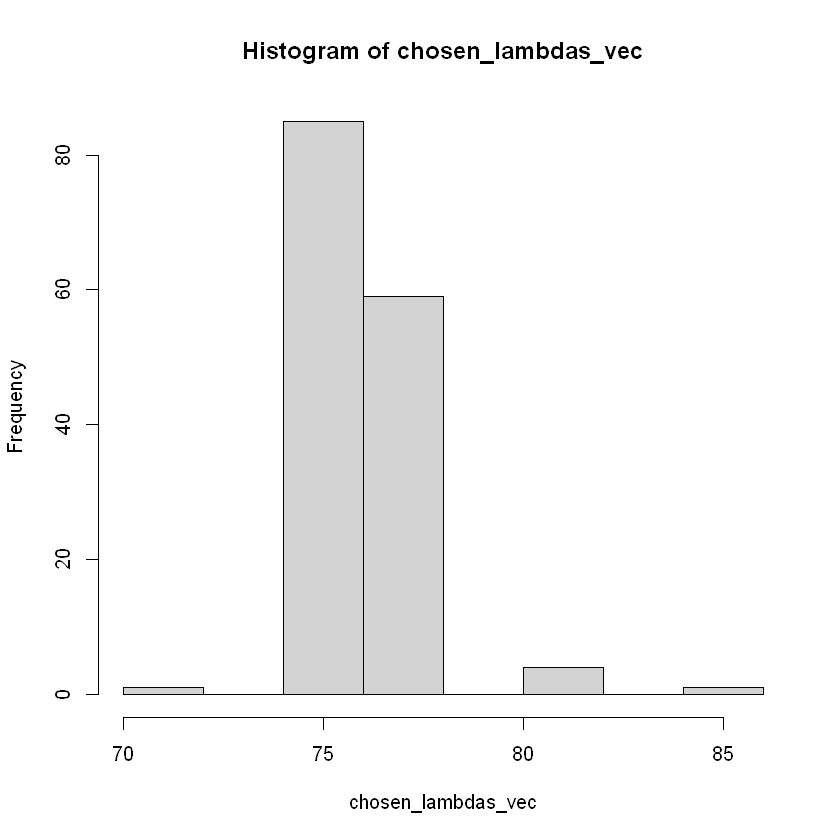

In [109]:
hist(chosen_lambdas_vec)

## Selecting a lambda from the data

In [25]:
selFun <- function(y) selFun_fixed_lambda(X, subjects, y, fixed_form, rand_form, lambda)

In [26]:
# and compute valid p-values conditional on the selection
# (this takes some time and will produce a lot of warnings)
suppressWarnings(res <- mocasin(final_model, this_y = y, conditional = FALSE,
               checkFun = checkFun, nrSamples = 100))

Computing inference for variable (location)  1 

  |======================================================================| 100%


Computing inference for variable (location)  2 

  |======================================================================| 100%


Computing inference for variable (location)  3 

  |======================================================================| 100%


Computing inference for variable (location)  4 

  |======================================================================| 100%


Computing inference for variable (location)  5 

  |======================================================================| 100%


Computing inference for variable (location)  6 

  |======================================================================| 100%


Computing inference for variable (location)  7 

  |======================================================================| 100%


Computing inference for variable (location)  8 

  |===============================

In [29]:
# create a boolean vector for the ones selected with BH-procedure at a certain fdr level

sel_vec2 <- selection_with_selinf(res,sel_vec,0.1)
metrics(sel_vec2,c(1,beta!=0))

$tpr
[1] 0.04761905

$fdr
[1] 0